**Deliverables in this notebook**
- Aggregation & metrics per family (sales, seasonality index, promo rate, promo lift, sparsity)
- Required visualizations (bar, pie, stacked area, heatmap, boxplots, promo comparison, trends)
- Answers to analysis questions (80/20, seasonality, promotion response, growth/decline, variance, correlations)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [4]:
# ====== 1) Load data ======
# Set this path to where your train.csv lives.

PATH = r'D:\Topic_13_Project\Topic_13_Retail_Store_Sales_Time_Series\data\raw\train.csv'

usecols = ["id", "date", "store_nbr", "family", "sales", "onpromotion"]
dtypes = {
    "id": "int32",
    "store_nbr": "int16",
    "family": "category",
    "sales": "float32",
    "onpromotion": "float32",  # keep float to allow missing
}

train = pd.read_csv(PATH, usecols=usecols, dtype=dtypes, parse_dates=["date"])
train["promo_flag"] = (train["onpromotion"].fillna(0) > 0).astype("int8")

print("Shape:", train.shape)
print("Date range:", train["date"].min().date(), "→", train["date"].max().date())
print("Families:", train["family"].nunique())

train.head(5)

Shape: (3000888, 7)
Date range: 2013-01-01 → 2017-08-15
Families: 33


,id,date,store_nbr,family,sales,onpromotion,promo_flag
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0.0,0


In [5]:
# Quick checks (as in template style)
train.info()
train.describe(include="all")
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 7 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int32         
 1   date         datetime64[ns]
 2   store_nbr    int16         
 3   family       category      
 4   sales        float32       
 5   onpromotion  float32       
 6   promo_flag   int8          
dtypes: category(1), datetime64[ns](1), float32(2), int16(1), int32(1), int8(1)
memory usage: 68.7 MB


id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
promo_flag     0
dtype: int64

## 2) Aggregations (family-day) + core metrics

We build a **family-day** panel (1 row = 1 family on 1 date, aggregated over all stores).
This is the basis for:
- trends and stacked-area plots
- seasonality heatmap (family × month)
- zero-sales day rate (sparsity)


In [6]:
# 2) Family-day aggregation
sales = train["sales"].to_numpy()
promo = train["promo_flag"].to_numpy()

tmp = train[["date", "family"]].copy()
tmp["daily_sales"] = sales
tmp["promo_sales"] = sales * promo
tmp["nonpromo_sales"] = sales * (1 - promo)
tmp["promo_any"] = promo

daily = tmp.groupby(["date", "family"], as_index=False).agg(
    daily_sales=("daily_sales", "sum"),
    promo_sales=("promo_sales", "sum"),
    nonpromo_sales=("nonpromo_sales", "sum"),
    promo_any=("promo_any", "max"),
)

# Create full grid (all dates × all families) to measure sparsity consistently
all_dates = pd.date_range(train["date"].min(), train["date"].max(), freq="D")
all_families = train["family"].cat.categories

grid = pd.MultiIndex.from_product([all_dates, all_families], names=["date","family"]).to_frame(index=False)
daily_full = grid.merge(daily, on=["date","family"], how="left")

for c in ["daily_sales","promo_sales","nonpromo_sales","promo_any"]:
    daily_full[c] = daily_full[c].fillna(0)
daily_full["promo_any"] = daily_full["promo_any"].astype("int8")

daily_full["month"] = daily_full["date"].dt.month
daily_full["year"] = daily_full["date"].dt.year

daily_full.head()

C:\Users\GIGABYTE\AppData\Local\Temp\ipykernel_36268\2974682269.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  daily = tmp.groupby(["date", "family"], as_index=False).agg(


,date,family,daily_sales,promo_sales,nonpromo_sales,promo_any,month,year
0,2013-01-01,AUTOMOTIVE,0.0,0.0,0.0,0,1,2013
1,2013-01-01,BABY CARE,0.0,0.0,0.0,0,1,2013
2,2013-01-01,BEAUTY,2.0,0.0,2.0,0,1,2013
3,2013-01-01,BEVERAGES,810.0,0.0,810.0,0,1,2013
4,2013-01-01,BOOKS,0.0,0.0,0.0,0,1,2013


In [7]:
# 3) Family-level metrics
# (A) Sales & sparsity & variance (daily)
family_daily_metrics = daily_full.groupby("family").agg(
    total_sales=("daily_sales","sum"),
    avg_daily_sales=("daily_sales","mean"),
    median_daily_sales=("daily_sales","median"),
    std_daily_sales=("daily_sales","std"),
    zero_day_rate=("daily_sales", lambda s: (s==0).mean()),
    promo_day_rate=("promo_any","mean"),
    promo_sales_share=("promo_sales", lambda s: s.sum()/(daily_full.loc[s.index,"daily_sales"].sum()+1e-9))
).reset_index()

family_daily_metrics["cv_daily"] = family_daily_metrics["std_daily_sales"]/(family_daily_metrics["avg_daily_sales"]+1e-9)

# (B) Promo effectiveness (record-level; more stable than day-level for big dataset)
g = train.groupby("family")

record_metrics = g.agg(
    n_records=("sales","size"),
    total_sales_record=("sales","sum"),
    promo_record_rate=("promo_flag","mean"),
).reset_index()

promo_means = g.apply(lambda df: pd.Series({
    "mean_sales_promo_record": df.loc[df["promo_flag"]==1, "sales"].mean(),
    "mean_sales_nonpromo_record": df.loc[df["promo_flag"]==0, "sales"].mean(),
    "promo_sales_sum": df.loc[df["promo_flag"]==1, "sales"].sum(),
})).reset_index()

record_metrics = record_metrics.merge(promo_means, on="family", how="left")
record_metrics["promo_sales_share_record"] = record_metrics["promo_sales_sum"]/(record_metrics["total_sales_record"]+1e-9)
record_metrics["promo_lift_record"] = (record_metrics["mean_sales_promo_record"]/(record_metrics["mean_sales_nonpromo_record"]+1e-9))-1

# (C) Family availability window (first/last positive day)
first_pos = daily_full.groupby("family").apply(lambda g: g.loc[g["daily_sales"]>0, "date"].min()).reset_index(name="first_positive_date")
last_pos  = daily_full.groupby("family").apply(lambda g: g.loc[g["daily_sales"]>0, "date"].max()).reset_index(name="last_positive_date")

# Merge all metrics
family_metrics = (family_daily_metrics
                  .merge(record_metrics, on="family", how="left")
                  .merge(first_pos, on="family", how="left")
                  .merge(last_pos, on="family", how="left")
                 )

family_metrics["sales_share"] = family_metrics["total_sales"] / family_metrics["total_sales"].sum()
family_metrics = family_metrics.sort_values("total_sales", ascending=False)

family_metrics.head(10)

C:\Users\GIGABYTE\AppData\Local\Temp\ipykernel_36268\298925039.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = train.groupby("family")
C:\Users\GIGABYTE\AppData\Local\Temp\ipykernel_36268\298925039.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  promo_means = g.apply(lambda df: pd.Series({
C:\Users\GIGABYTE\AppData\Local\Temp\ipykernel_36268\298925039.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of panda

,family,total_sales,avg_daily_sales,median_daily_sales,std_daily_sales,zero_day_rate,promo_day_rate,promo_sales_share,cv_daily,n_records,total_sales_record,promo_record_rate,mean_sales_promo_record,mean_sales_nonpromo_record,promo_sales_sum,promo_sales_share_record,promo_lift_record,first_positive_date,last_positive_date,sales_share
12,GROCERY I,343462720.0,203473.171875,194539.304688,62551.091474,0.002370,0.727488,0.730572,0.307417,90936,343462720.0,0.625561,4411.003418,2717.720947,250924352.0,0.730572,0.623052,2013-01-01,2017-08-15,0.319903
3,BEVERAGES,216954480.0,128527.539062,128100.500000,63357.371644,0.002370,0.719787,0.766324,0.492948,90936,216954480.0,0.568587,3215.498291,1292.272583,166257344.0,0.766324,1.488251,2013-01-01,2017-08-15,0.202073
30,PRODUCE,122704688.0,72692.351562,96329.914062,61875.456147,0.046209,0.572867,0.611698,0.851196,90936,122704688.0,0.338524,2438.220215,792.101868,75058168.0,0.611698,2.078165,2013-03-16,2017-08-15,0.114288
7,CLEANING,97521288.0,57773.273438,55204.000000,15452.685747,0.002370,0.725118,0.634595,0.267471,90936,97521288.0,0.548738,1240.210693,868.378418,61886512.0,0.634595,0.428192,2013-01-01,2017-08-15,0.090832
8,DAIRY,64487708.0,38203.617188,37873.500000,13835.457031,0.002370,0.722156,0.665549,0.362150,90936,64487708.0,0.505685,933.341675,479.811096,42919716.0,0.665549,0.945227,2013-01-01,2017-08-15,0.060064
5,BREAD/BAKERY,42133944.0,24960.867188,24407.533203,6616.928175,0.002370,0.719194,0.531260,0.265092,90936,42133944.0,0.427729,575.485291,379.513245,22384076.0,0.531260,0.516377,2013-01-01,2017-08-15,0.039244
28,POULTRY,31876004.0,18883.888672,18224.054688,6140.614079,0.002370,0.639218,0.299804,0.325177,90936,31876004.0,0.216680,485.006104,313.334503,9556560.0,0.299804,0.547886,2013-01-01,2017-08-15,0.029690
24,MEATS,31086468.0,18416.154297,17731.718750,4421.024836,0.002370,0.689573,0.322714,0.240062,90936,31086468.0,0.236078,467.301605,303.081116,10032031.0,0.322714,0.541837,2013-01-01,2017-08-15,0.028954
25,PERSONAL CARE,24592052.0,14568.750977,13513.000000,5401.789302,0.002370,0.695498,0.526618,0.370779,90936,24592052.0,0.420417,338.746704,220.878967,12950625.0,0.526618,0.533630,2013-01-01,2017-08-15,0.022905
9,DELI,24110322.0,14283.366211,13870.437012,4224.560811,0.002370,0.720972,0.526706,0.295768,90936,24110322.0,0.434140,321.665802,221.763382,12699044.0,0.526706,0.450491,2013-01-01,2017-08-15,0.022457


In [8]:
# Save metrics table for reporting
family_metrics.to_csv("family_metrics.csv", index=False)
print("Saved: family_metrics.csv")

Saved: family_metrics.csv


## 3) Required Visualizations

In [9]:
# Helper: choose top K families by total sales
TOP15 = family_metrics.head(15)["family"].tolist()
TOP10 = family_metrics.head(10)["family"].tolist()
TOP8  = family_metrics.head(8)["family"].tolist()
TOP5  = family_metrics.head(5)["family"].tolist()


### 3.1 Bar chart — Top 15 families by total sales

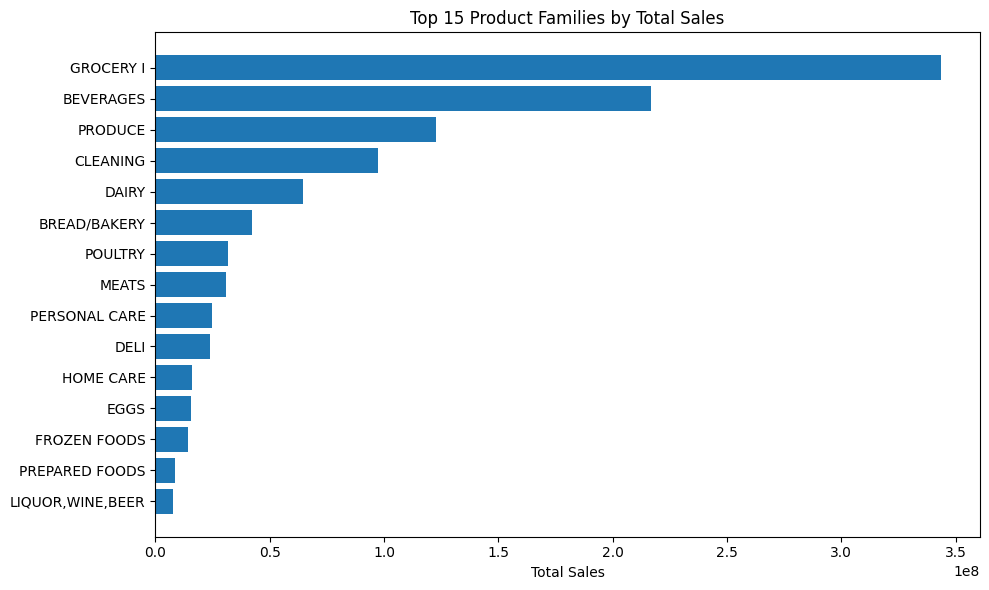

In [10]:
top15 = family_metrics.head(15).sort_values("total_sales", ascending=True)

plt.figure(figsize=(10,6))
plt.barh(top15["family"].astype(str), top15["total_sales"])
plt.title("Top 15 Product Families by Total Sales")
plt.xlabel("Total Sales")
plt.tight_layout()
plt.show()

### 3.2 Pie chart — Sales composition (Top 10 + Other)

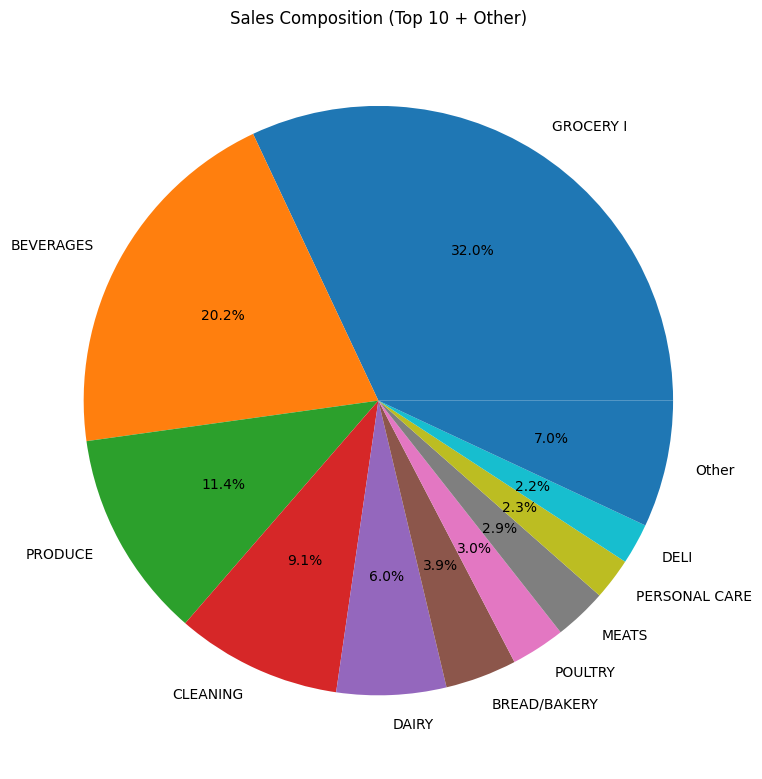

In [11]:
K = 10
topk = family_metrics.head(K).copy()
other_sales = family_metrics["total_sales"].iloc[K:].sum()

labels = list(topk["family"].astype(str)) + ["Other"]
sizes = list(topk["total_sales"]) + [other_sales]

plt.figure(figsize=(8,8))
plt.pie(sizes, labels=labels, autopct="%1.1f%%")
plt.title(f"Sales Composition (Top {K} + Other)")
plt.tight_layout()
plt.show()

### 3.3 Stacked area — Sales contribution by family over time (Top 8 + Other)

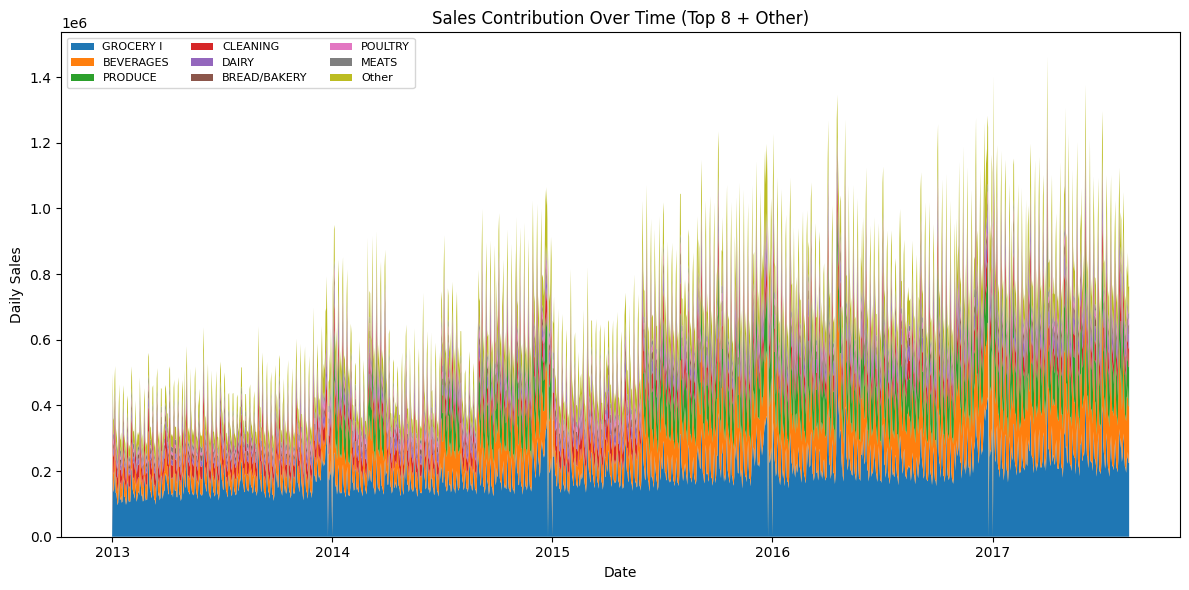

In [12]:
ts = daily_full.pivot_table(index="date", columns="family", values="daily_sales", aggfunc="sum").sort_index()
ts_top = ts[TOP8].copy()
ts_top["Other"] = ts.drop(columns=TOP8).sum(axis=1)

plt.figure(figsize=(12,6))
plt.stackplot(ts_top.index, ts_top.T.values, labels=[str(c) for c in ts_top.columns])
plt.title("Sales Contribution Over Time (Top 8 + Other)")
plt.xlabel("Date"); plt.ylabel("Daily Sales")
plt.legend(loc="upper left", ncol=3, fontsize=8)
plt.tight_layout()
plt.show()

### 3.4 Heatmap — Family × Month seasonality index (Top 20)

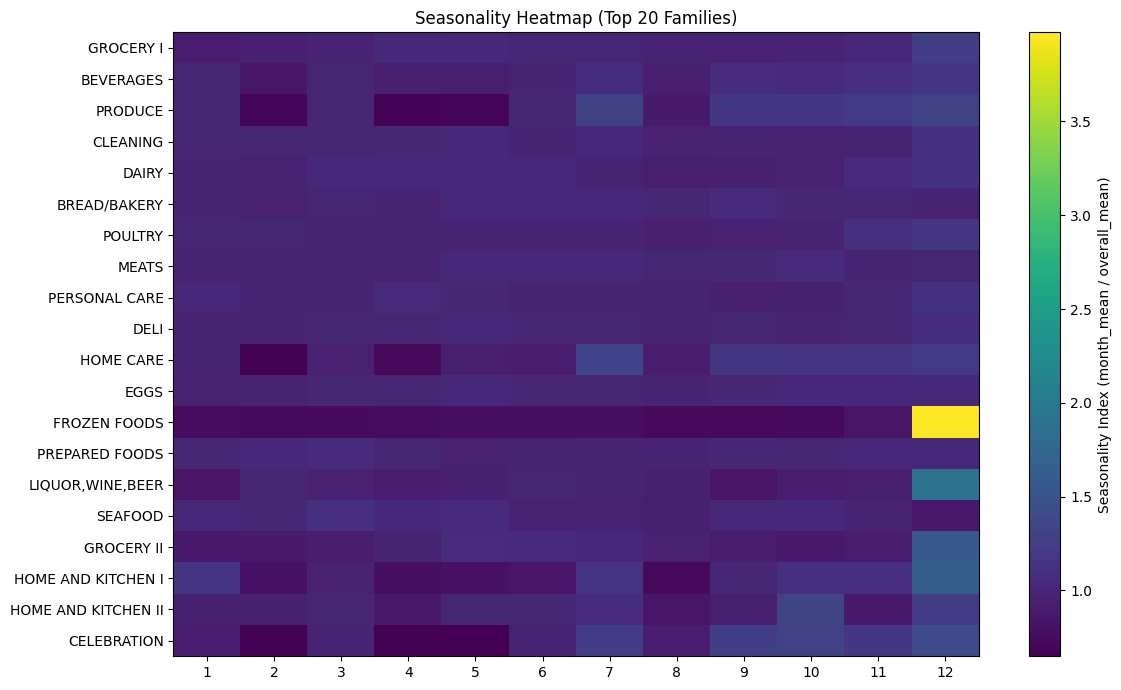

In [13]:
# Seasonality index = (mean daily sales in month) / (overall mean daily sales)
month_mean = daily_full.groupby(["family","month"])["daily_sales"].mean().reset_index(name="month_mean_daily_sales")
overall_mean = daily_full.groupby("family")["daily_sales"].mean().reset_index(name="overall_mean_daily_sales")
month_mean = month_mean.merge(overall_mean, on="family", how="left")
month_mean["seasonality_index"] = month_mean["month_mean_daily_sales"]/(month_mean["overall_mean_daily_sales"]+1e-9)

heat = month_mean.pivot(index="family", columns="month", values="seasonality_index")
top20 = family_metrics.head(20)["family"].tolist()
heat = heat.loc[top20]

plt.figure(figsize=(12,7))
plt.imshow(heat.values, aspect="auto")
plt.colorbar(label="Seasonality Index (month_mean / overall_mean)")
plt.yticks(range(len(heat.index)), [str(x) for x in heat.index])
plt.xticks(range(12), list(range(1,13)))
plt.title("Seasonality Heatmap (Top 20 Families)")
plt.tight_layout()
plt.show()

### 3.5 Box plots — Daily sales distribution (Top 10 families)

C:\Users\GIGABYTE\AppData\Local\Temp\ipykernel_36268\1977527887.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_data, labels=[str(f) for f in TOP10], showfliers=False)


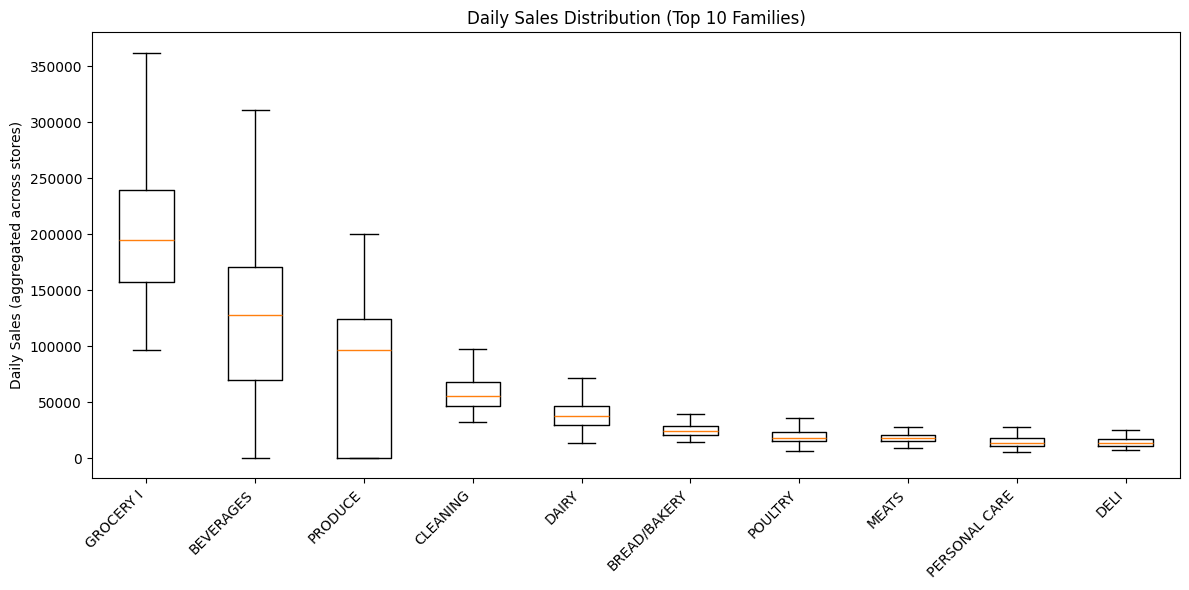

In [14]:
box_data = [daily_full.loc[daily_full["family"]==f, "daily_sales"].values for f in TOP10]

plt.figure(figsize=(12,6))
plt.boxplot(box_data, labels=[str(f) for f in TOP10], showfliers=False)
plt.xticks(rotation=45, ha="right")
plt.title("Daily Sales Distribution (Top 10 Families)")
plt.ylabel("Daily Sales (aggregated across stores)")
plt.tight_layout()
plt.show()

### 3.6 Promo comparison — Sales with vs without promotion (Top 10 families)

C:\Users\GIGABYTE\AppData\Local\Temp\ipykernel_36268\1513511661.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cmp = sub.groupby(["family","promo_flag"])["sales"].mean().reset_index()


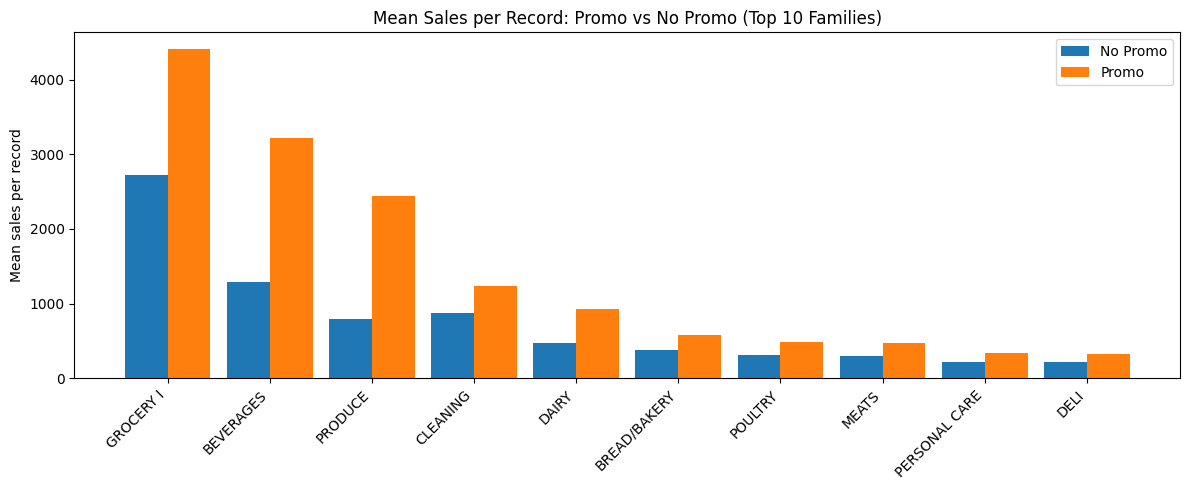

In [15]:
# Compare mean sales per record for promo vs non-promo (Top 10)
sub = train[train["family"].isin(TOP10)].copy()
cmp = sub.groupby(["family","promo_flag"])["sales"].mean().reset_index()

pivot = cmp.pivot(index="family", columns="promo_flag", values="sales").rename(columns={0:"No Promo", 1:"Promo"}).fillna(0)
pivot = pivot.loc[TOP10]  # keep order

x = np.arange(len(pivot.index))
width = 0.42

plt.figure(figsize=(12,5))
plt.bar(x - width/2, pivot["No Promo"], width, label="No Promo")
plt.bar(x + width/2, pivot["Promo"], width, label="Promo")
plt.xticks(x, [str(i) for i in pivot.index], rotation=45, ha="right")
plt.title("Mean Sales per Record: Promo vs No Promo (Top 10 Families)")
plt.ylabel("Mean sales per record")
plt.legend()
plt.tight_layout()
plt.show()

### 3.7 Line charts — Trends of top families over time (7-day rolling mean)

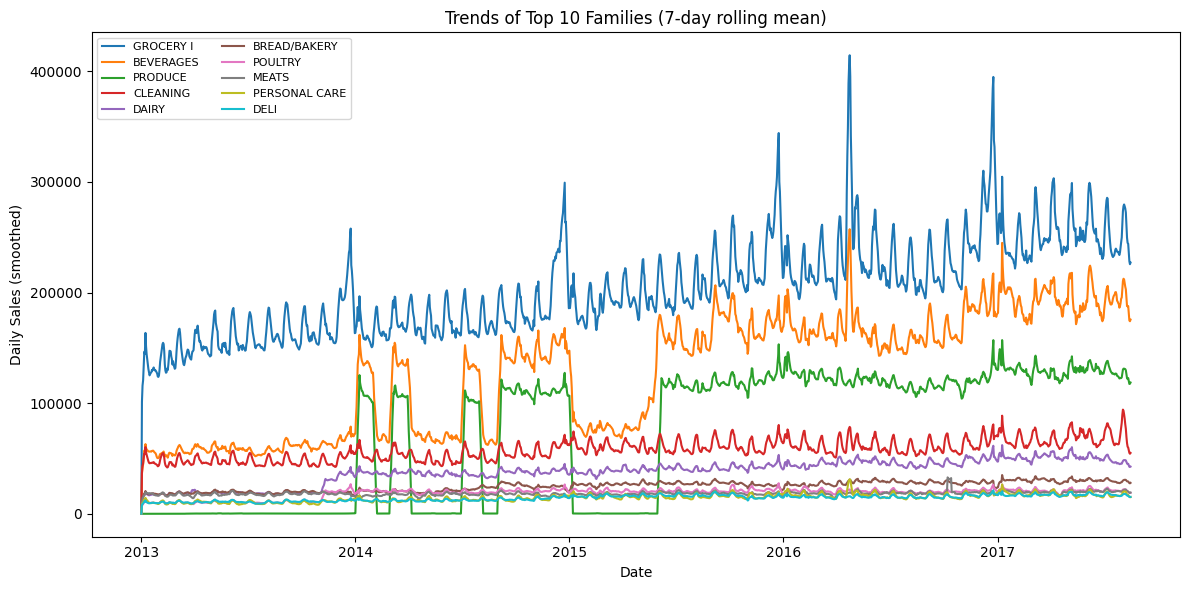

In [16]:
# Smooth with rolling mean for readability
ts_top10 = daily_full[daily_full["family"].isin(TOP10)].pivot_table(index="date", columns="family", values="daily_sales", aggfunc="sum").sort_index()
ts_smooth = ts_top10.rolling(7, min_periods=1).mean()

plt.figure(figsize=(12,6))
for f in TOP10:
    plt.plot(ts_smooth.index, ts_smooth[f], label=str(f))
plt.title("Trends of Top 10 Families (7-day rolling mean)")
plt.xlabel("Date"); plt.ylabel("Daily Sales (smoothed)")
plt.legend(ncol=2, fontsize=8)
plt.tight_layout()
plt.show()

## 4) Analysis Questions (computed outputs)

We compute the key answers programmatically so the notebook stays reproducible.


In [17]:
# 80/20 rule
fm = family_metrics.copy()
fm["cum_share"] = fm["sales_share"].cumsum()
n80 = int(np.argmax(fm["cum_share"].to_numpy() >= 0.80)) + 1
core80 = fm.head(n80)[["family","total_sales","sales_share","cum_share"]]

print("Families needed to reach ~80% of sales:", n80)
core80

Families needed to reach ~80% of sales: 6


,family,total_sales,sales_share,cum_share
12,GROCERY I,343462720.0,0.319903,0.319903
3,BEVERAGES,216954480.0,0.202073,0.521976
30,PRODUCE,122704688.0,0.114288,0.636264
7,CLEANING,97521288.0,0.090832,0.727096
8,DAIRY,64487708.0,0.060064,0.787161
5,BREAD/BAKERY,42133944.0,0.039244,0.826404


In [18]:
# Strong seasonality families (top by seasonality range)
season_strength = month_mean.groupby("family")["seasonality_index"].agg(["min","max"]).reset_index()
season_strength["seasonality_range"] = season_strength["max"] - season_strength["min"]
season_strength = season_strength.sort_values("seasonality_range", ascending=False)

season_strength.head(10)

,family,min,max,seasonality_range
4,BOOKS,0.000000,3.770085,3.770085
31,SCHOOL AND OFFICE SUPPLIES,0.204657,3.766545,3.561888
11,FROZEN FOODS,0.731988,3.974650,3.242662
22,"LIQUOR,WINE,BEER",0.818666,1.889347,1.070680
27,PLAYERS AND ELECTRONICS,0.646621,1.597594,0.950973
15,HOME AND KITCHEN I,0.730333,1.628488,0.898156
6,CELEBRATION,0.649218,1.422817,0.773598
1,BABY CARE,0.645183,1.409326,0.764143
19,LADIESWEAR,0.630830,1.340976,0.710146
13,GROCERY II,0.876933,1.578695,0.701761


In [19]:
# Promo responders among top sales families (rank by promo_lift_record)
top15 = family_metrics.head(15)["family"].tolist()
promo_rank = family_metrics[family_metrics["family"].isin(top15)][
    ["family","total_sales","promo_record_rate","promo_sales_share_record","promo_lift_record"]
].sort_values("promo_lift_record", ascending=False)

promo_rank

,family,total_sales,promo_record_rate,promo_sales_share_record,promo_lift_record
30,PRODUCE,122704688.0,0.338524,0.611698,2.078165
18,HOME CARE,16022744.0,0.357812,0.628402,2.035082
3,BEVERAGES,216954480.0,0.568587,0.766324,1.488251
11,FROZEN FOODS,14073888.0,0.393903,0.582831,1.149720
8,DAIRY,64487708.0,0.505685,0.665549,0.945227
12,GROCERY I,343462720.0,0.625561,0.730572,0.623052
22,"LIQUOR,WINE,BEER",7746640.0,0.197029,0.279155,0.578248
28,POULTRY,31876004.0,0.216680,0.299804,0.547886
24,MEATS,31086468.0,0.236078,0.322714,0.541837
25,PERSONAL CARE,24592052.0,0.420417,0.526618,0.533630


In [20]:
# Growth / decline (annual totals 2014→2016)
daily_full["year"] = daily_full["date"].dt.year
annual = daily_full.groupby(["year","family"], as_index=False)["daily_sales"].sum().rename(columns={"daily_sales":"annual_sales"})
annual_pivot = annual.pivot(index="family", columns="year", values="annual_sales")

growth_2014_2016 = ((annual_pivot[2016]/(annual_pivot[2014]+1e-9))-1).sort_values(ascending=False)
growth_2014_2016.head(10), growth_2014_2016.tail(10)

(family
 BOOKS                         4.119000e+12
 BABY CARE                     7.345719e+00
 MAGAZINES                     7.298474e+00
 HOME AND KITCHEN II           2.936382e+00
 SCHOOL AND OFFICE SUPPLIES    1.539190e+00
 PET SUPPLIES                  1.280979e+00
 CELEBRATION                   9.577147e-01
 PRODUCE                       8.818946e-01
 HOME CARE                     8.709533e-01
 PLAYERS AND ELECTRONICS       8.443574e-01
 dtype: float32,
 family
 CLEANING           0.160601
 PREPARED FOODS     0.136539
 MEATS              0.098507
 EGGS               0.091448
 HARDWARE           0.079334
 SEAFOOD            0.064020
 GROCERY II         0.021365
 POULTRY            0.017457
 LINGERIE          -0.278507
 HOME APPLIANCES   -0.285308
 dtype: float32)

In [21]:
# High variance / sparsity
family_metrics.sort_values("cv_daily", ascending=False)[
    ["family","total_sales","zero_day_rate","cv_daily","first_positive_date"]
].head(12)

,family,total_sales,zero_day_rate,cv_daily,first_positive_date
4,BOOKS,6438.0,0.829976,3.396683,2016-10-08
31,SCHOOL AND OFFICE SUPPLIES,269316.0,0.398104,2.686748,2014-01-02
1,BABY CARE,10051.0,0.472156,1.333979,2014-03-01
11,FROZEN FOODS,14073888.0,0.002370,1.237033,2013-01-01
23,MAGAZINES,266359.0,0.360190,1.135251,2014-01-01
20,LAWN AND GARDEN,548842.0,0.002370,1.047153,2013-01-01
19,LADIESWEAR,651159.0,0.398104,0.987417,2014-01-02
26,PET SUPPLIES,356584.0,0.392180,0.933044,2014-01-01
27,PLAYERS AND ELECTRONICS,562608.0,0.396327,0.925196,2014-01-01
6,CELEBRATION,761177.0,0.396327,0.906827,2014-01-01


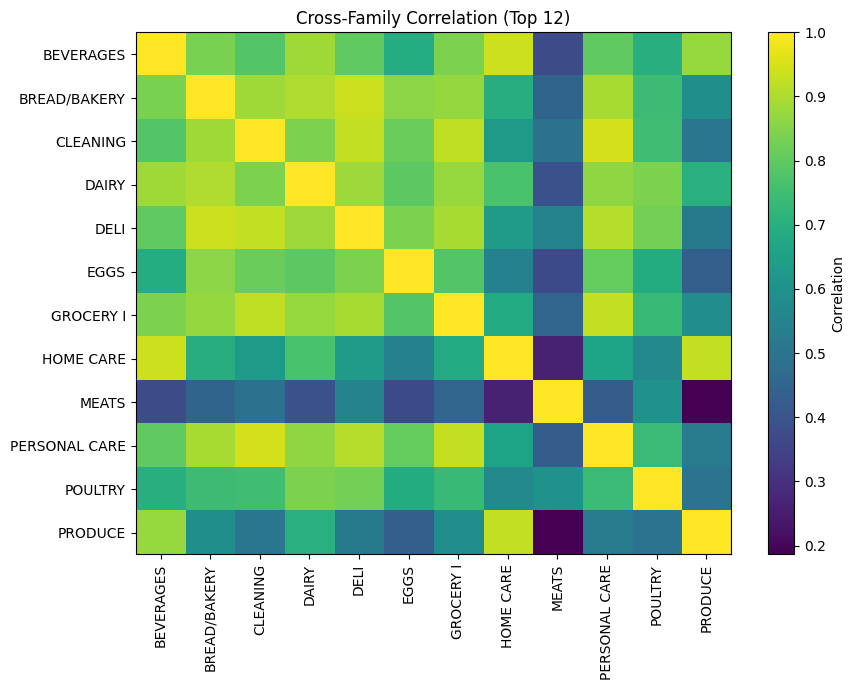

[('CLEANING', 'PERSONAL CARE', 0.9477185892005174),
 ('BEVERAGES', 'HOME CARE', 0.939193399439492),
 ('BREAD/BAKERY', 'DELI', 0.9356017877906083),
 ('CLEANING', 'DELI', 0.9258302426922509),
 ('GROCERY I', 'PERSONAL CARE', 0.924644946370123),
 ('HOME CARE', 'PRODUCE', 0.9246169803385396),
 ('CLEANING', 'GROCERY I', 0.9210257138799781),
 ('DELI', 'PERSONAL CARE', 0.9095704812856741),
 ('BREAD/BAKERY', 'DAIRY', 0.901663417538819),
 ('DELI', 'GROCERY I', 0.8940844399868861)]

In [22]:
# Cross-family correlations (top 12 families)
top12 = family_metrics.head(12)["family"].tolist()
pivot = daily_full[daily_full["family"].isin(top12)].pivot_table(index="date", columns="family", values="daily_sales", aggfunc="sum").sort_index()
corr = pivot.corr()

plt.figure(figsize=(9,7))
plt.imshow(corr.values, aspect="auto")
plt.colorbar(label="Correlation")
plt.xticks(range(len(top12)), [str(x) for x in corr.columns], rotation=90)
plt.yticks(range(len(top12)), [str(x) for x in corr.index])
plt.title("Cross-Family Correlation (Top 12)")
plt.tight_layout()
plt.show()

# List top correlated pairs
pairs=[]
cols=corr.columns
for i in range(len(cols)):
    for j in range(i+1,len(cols)):
        pairs.append((cols[i], cols[j], float(corr.iloc[i,j])))
pairs_sorted = sorted(pairs, key=lambda x: abs(x[2]), reverse=True)
pairs_sorted[:10]